deltax = 0.05
deltat = 0.0005
lambda = 0.19999999999999996


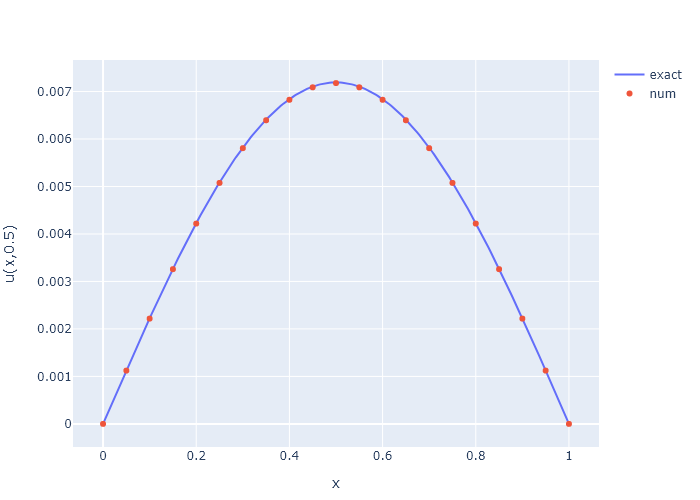

In [86]:
using PlotlyJS
using LinearAlgebra

# Set problem parameters/functions
kappa = 1   # diffusion constant
L = 1.0         # length of spatial domain
T = 0.5         # total time to solve for

function u_I(x)
    # initial temperature distribution
    y = sin.(pi*x/L)
    return y
end
function u_exact(x,t)
    # the exact solution
    y = exp.(-kappa*(pi^2/L^2)*t)*sin.(pi*x/L)
    return y
end
# Set numerical parameters
mx = 20     # number of gridpoints in space
mt = 1000   # number of gridpoints in time

# Set up the numerical environment variables
x = LinRange(0, L, mx+1)     # mesh points in space
t = LinRange(0, T, mt+1)     # mesh points in time
deltax = x[2] - x[1]            # gridspacing in x
deltat = t[2] - t[1]            # gridspacing in t
lmbda = kappa*deltat/(deltax^2)    # mesh fourier number
println("deltax = ", deltax)
println("deltat = ", deltat)
println("lambda = ", lmbda)

# Set up the solution variables
u_j = zeros(size(x))        # u at current time step
u_jp1 = zeros(size(x))      # u at next time step

# Set initial condition
for i in 1:mx+1
    u_j[i] = u_I(x[i])
end

# Solve the PDE: loop over all time points
for j in 1:mt
    # Forward Euler timestep at inner mesh points
    # PDE discretised at position x[i], time t[j]
    for i in 2:mx
        u_jp1[i] = u_j[i] + lmbda*(u_j[i-1] - 2*u_j[i] + u_j[i+1])
    end
    # Boundary conditions
    u_jp1[1] = 0; u_jp1[mx+1] = 0
        
    # Save u_j at time t[j+1]
    u_j[:] = u_jp1[:]
end

# Plot the final result and exact solution
xx = LinRange(0,L,250)

# Create traces
exact = scatter(x=xx, y=u_exact(xx,T), mode="lines", name="exact", showlegend=true)
num = scatter(x=x, y=u_j, mode="markers", name="num", showlegend=true)

layout = Layout(
    xaxis_title = "x",
    yaxis_title = "u(x,0.5)"
    )

plot([exact, num], layout)

In [85]:
function forward_euler(u_I, kappa, L, T, mx, mt)

    using LinearAlgebra

    # Set up the numerical environment variables
    x = LinRange(0, L, mx+1)     # mesh points in space
    t = LinRange(0, T, mt+1)     # mesh points in time
    deltax = x[2] - x[1]            # gridspacing in x
    deltat = t[2] - t[1]            # gridspacing in t
    lmbda = kappa*deltat/(deltax^2)    # mesh fourier number
    println("deltax = ", deltax)
    println("deltat = ", deltat)
    println("lambda = ", lmbda)

    # Create A_FE matrix
    A_FE = Tridiagonal(ones(mx-1)*(lmbda), ones(mx)*(1 - 2*lmbda), ones(mx-1)*(lmbda))

    # Set up the solution variables
    u_j = zeros(size(x))        # u at current time step
    u_jp1 = zeros(size(x))      # u at next time step

    # Set initial condition
    for i in 1:mx+1
        u_j[i] = u_I(x[i])
    end

    # Solve the PDE: loop over all time points
    for j in 1:mt
        # Forward Euler timestep at inner mesh points
        # PDE discretised at position x[i], time t[j]
        for i in 2:mx
            u_jp1[i] = u_j[i] + lmbda*(u_j[i-1] - 2*u_j[i] + u_j[i+1])
        end

        u_jp1[2:end] = A_FE*(u_j[2:end])

        # Boundary conditions
        u_jp1[1] = 0
        u_jp1[mx+1] = 0
            
        # Save u_j at time t[j+1]
        u_j[:] = u_jp1[:]
    end

    # println("x: ", x)
    # println("u_j: ", u_j) 
    return x, u_j
end

forward_euler (generic function with 1 method)

deltax = 0.1
deltat = 0.0005
lambda = 0.04999999999999999


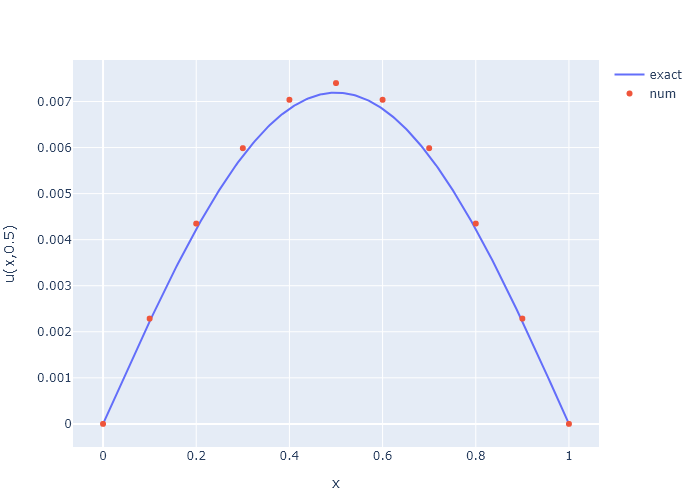

In [87]:
kappa = 1   # diffusion constant
L = 1.0         # length of spatial domain
T = 0.5         # total time to solve for

function u_I(x)
    # initial temperature distribution
    y = sin.(pi*x/L)
    return y
end

function u_exact(x,t)
    # the exact solution
    y = exp.(-kappa*(pi^2/L^2)*t)*sin.(pi*x/L)
    return y
end

# Set numerical parameters
mx = 10     # number of gridpoints in space
mt = 1000   # number of gridpoints in time

x, u_j = forward_euler(u_I, kappa, L, T, mx, mt);

# Plot the final result and exact solution
using PlotlyJS
xx = LinRange(0,L,250)

# Create traces
exact = scatter(x=xx, y=u_exact(xx,T), mode="lines", name="exact", showlegend=true)
num = scatter(x=x, y=u_j, mode="markers", name="num", showlegend=true)

layout = Layout(
    xaxis_title = "x",
    yaxis_title = "u(x,0.5)"
    )

plot([exact, num], layout)

In [73]:
using LinearAlgebra

lmbda = 2
mx = 5
D = Tridiagonal(ones(mx-1)*(lmbda), ones(mx)*(1 - 2*lmbda), ones(mx-1)*(lmbda))

5×5 Tridiagonal{Float64, Vector{Float64}}:
 -3.0   2.0    ⋅     ⋅     ⋅ 
  2.0  -3.0   2.0    ⋅     ⋅ 
   ⋅    2.0  -3.0   2.0    ⋅ 
   ⋅     ⋅    2.0  -3.0   2.0
   ⋅     ⋅     ⋅    2.0  -3.0

In [74]:
y = [1;2;3;4;5]
x = fill(2., (5,5))

D*y

5-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
 -7.0